In [1]:
from pynq import Overlay, MMIO, lib
from pynq.lib.video import VideoMode
from PIL import Image
import cffi
import time 
import cv2
from time import sleep

## Before starting this piece of code be sure that SW0 on board is in OFF position

In [2]:
overlay = Overlay("design_1.xsa")

Class to manage the convolution filter mapped on FPGA. It provides method to modify "on fly" the kernel (7x7)

In [3]:
class Convolution_Filter:
    def __init__(self, overlay, base_address=0x43C10000, address_range=0x10000, address_offset=0x40):
        self.base_address = base_address
        self.address_range = address_range
        self.address_offset = address_offset
        self.offset = 0x04
        self.mmio = MMIO(base_address, address_range)
        self.conv = overlay.filter.convolution_filter
        
    def update_filter(self, fil):
        if(len(fil) != 51):
            print("La lunghezza del filtro deve essere di 51 elementi")
            
        address = self.address_offset
        data = 0x00000000
        bits_shift = 0
        counter = 0
        
        for el in fil:
            if(bits_shift >= 32):
                self.mmio.write(address, data)
                data = 0x00000000
                bits_shift = 0
                address = address + self.offset
            
            counter += 1
            data = data | (el << bits_shift)
            bits_shift += 8
            if(counter >= 51):
                self.mmio.write(address, data)
    
    def print_filter(self):
        f1 = self.conv.mmio.array.view('int8')[0x40:0x71]
        f2 = self.conv.mmio.array.view('int8')[0x71:0x73]
        
        print(f1.reshape((7,7)))
        print(f2.reshape((1,2)))

Class to manage OV7670 sensor. It provides basic methods to write and read sensor's registers and a basic setup that works quite well in our configuration

In [4]:
class OV7670:
    def __init__(self, iic):
        self.OV7670_SLAVE_ADDRESS = 0x21
        
        _ffi = cffi.FFI()
        self.tx_buf = _ffi.new("unsigned char [32]")
        self.rx_buf = _ffi.new("unsigned char [32]")
        
        self.iic = iic

    def write_register(self, reg, data):
        self.tx_buf[0] = reg
        self.tx_buf[1] = data

        self.iic.send(self.OV7670_SLAVE_ADDRESS, self.tx_buf, 2, 0)

    def read_register(self, reg):
        self.tx_buf[0] = reg

        self.iic.send(self.OV7670_SLAVE_ADDRESS, self.tx_buf, 1, 0)
        self.iic.receive(self.OV7670_SLAVE_ADDRESS, self.rx_buf, 1, 0)

        return self.rx_buf[0]

    def default_setup(self):
        self.write_register(0x12, 0x80)
        sleep(1)
        self.write_register(0x0E, 0x01)
        self.write_register(0x0F, 0x4B)
        self.write_register(0x16, 0x02)
        self.write_register(0x1E, 0x07)
        self.write_register(0x21, 0x02)
        self.write_register(0x22, 0x91)
        self.write_register(0x29, 0x07)
        self.write_register(0x33, 0x0B)
        self.write_register(0x35, 0x0B)
        self.write_register(0x37, 0x1D)
        self.write_register(0x38, 0x01)
        self.write_register(0x0C, 0x00) 
        self.write_register(0x3C, 0x78)
        self.write_register(0x4D, 0x40)
        self.write_register(0x4E, 0x20)
        self.write_register(0x74, 0x10)
        self.write_register(0x8D, 0x4F)
        self.write_register(0x8E, 0x00)
        self.write_register(0x8F, 0x00)
        self.write_register(0x90, 0x00)
        self.write_register(0x91, 0x00)
        self.write_register(0x96, 0x00)
        self.write_register(0x9A, 0x00)
        self.write_register(0xB0, 0x84)
        self.write_register(0xB1, 0x04)
        self.write_register(0xB2, 0x0E)
        self.write_register(0xB3, 0x82)
        self.write_register(0xB8, 0x0A)

Usage example of OV7670 class to program sensor with a basic setup

In [5]:
iic = overlay.axi_iic
ov7670 = OV7670(iic)
ov7670.default_setup()

In [30]:
class PWM_class:
    def __init__(self, overlay, base_address=0x4000_0000, address_range=0x10000, address_offset=0x40):
        self.mmio = MMIO(base_address, address_range)
        self.base_address = base_address
        self.address_range = address_range
        self.address_offset = address_offset
        self.offset = 0x04
        self.pwm = overlay.PWM_Kotha_v1_0_0
        
    def update_PWM(self, data_1=5000, data_2=10000000):
        # Ensure offset for data_1 is within the range

#         address = self.base_address + self.offset
        address = self.offset
        print(f"Writing data_1={data_1} to offset {hex(address)}")
        self.mmio.write(address, data_1)  # Writing to the relative offset

        address += self.offset
        print(f"Writing data_2={data_2} to offset {hex(address)}")
        self.mmio.write(offset2, data_2)  # Writing to the next relative offset

        print("Update complete.")


## Before exexuting this piece of code set SW0 on

Usage example of convolution filter class

In [ ]:
pwm = PWM_class(overlay)
pwm.update_PWM()

In [ ]:
sharpen_filter = [
    1, 0, 0, 0, 0, 0, 0,
    0, 1, 0, 0, 0, 0, 0,
    0, 0, 1, 0, 0, 0, 0,
    0, 0, 0, 1, 0, 0, 0,
    0, 0, 0, 0, 1, 0, 0,
    0, 0, 0, 0, 0, 1, 0,
    0, 0, 0, 0, 0, 0, 1,
    7, 0]

neutral_filter = [
    0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 1, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    1, 0]

vertical_filter = [
	-1, -2, -4, 0, 4, 2, 1,
	-1, -2, -4, 0, 4, 2, 1,
	-2, -4, -6, 0, 6, 4, 2,
	-4, -6, -8, 0, 8, 6, 4,
	-2, -4, -6, 0, 6, 4, 2,
	-1, -2, -4, 0, 4, 2, 1,
	-1, -2, -4, 0, 4, 2, 1,
    120, 127]

fil = Convolution_Filter(overlay)
fil.update_filter(neutral_filter)

In [ ]:
# Configuration of vdma with a resolution of 800x600 and 24 bit for each pixel
vdma = overlay.VDMA.axi_vdma

vdma.readchannel.reset()
vdma.readchannel.mode = VideoMode(800, 600, 24)
vdma.readchannel.start()

vdma.writechannel.reset()
vdma.writechannel.mode = VideoMode(800, 600, 24)
vdma.writechannel.start()

frame = vdma.readchannel.readframe() # Needed because first frame is always black

vdma.readchannel.tie(vdma.writechannel) # Connect input directly to output of vdma

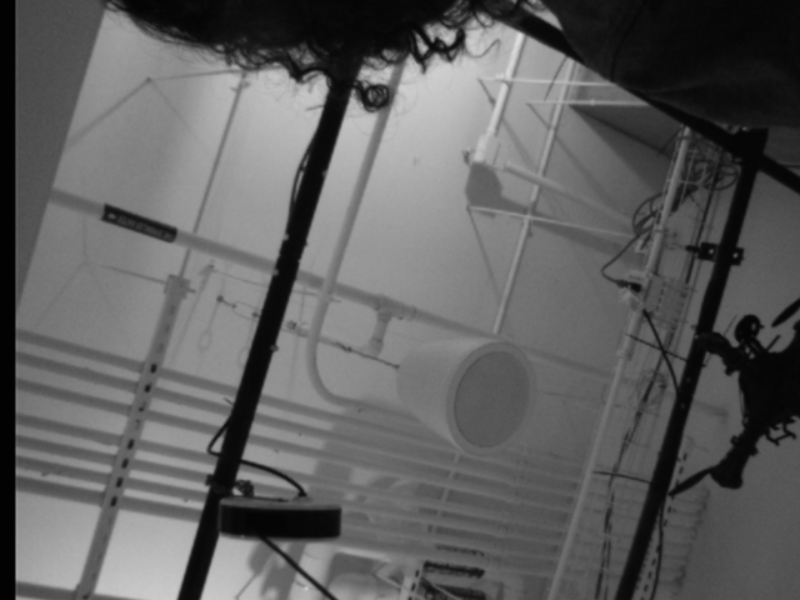

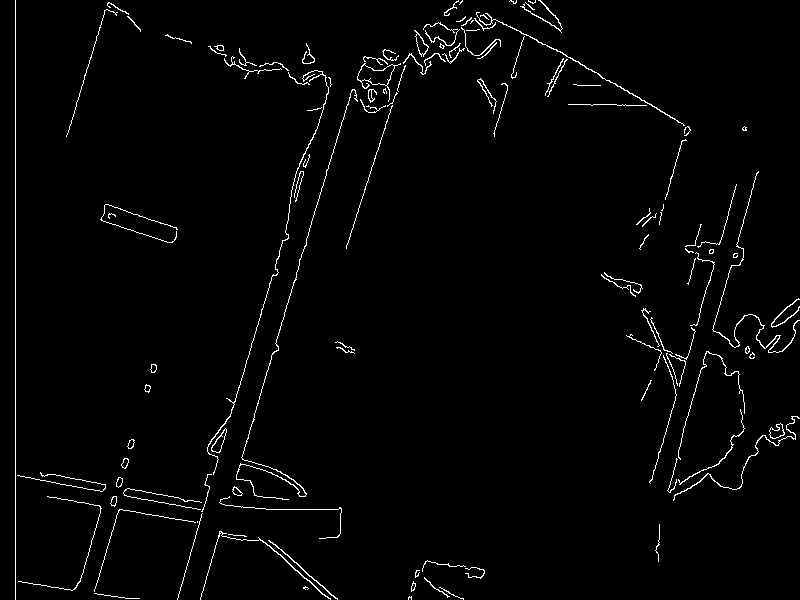

In [15]:
frame = vdma.readchannel.readframe()
img = Image.fromarray(frame, 'RGB')
display(img)
# img.save("img.png")

# Assuming 'frame' is your grayscale image from VDMA
edges = cv2.Canny(frame, 100, 200)

# Display the edges
edges_img = Image.fromarray(edges)
display(edges_img)

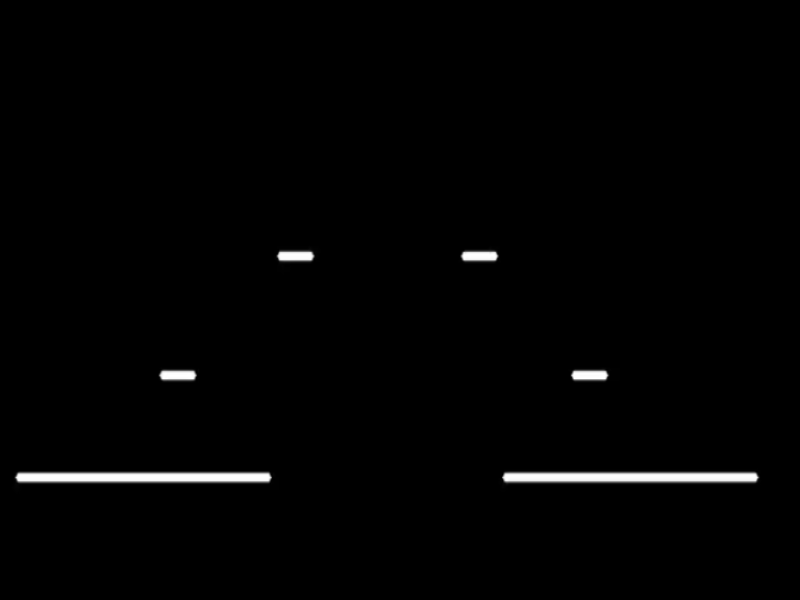

In [11]:
#import the mask and configure it based on a threshold (just some processing to make it compatible with our frames)
mask = cv2.imread('img_mask.PNG')
mask = cv2.resize(mask, (800,600))
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
#threshold_value = 100
#, mask = cv2.threshold(mask_gray, threshold_value, 255, cv2.THRESH_BINARY)

#display the mask 
mask_img = Image.fromarray(mask)
display(mask_img)


(600, 800)
(600, 800)


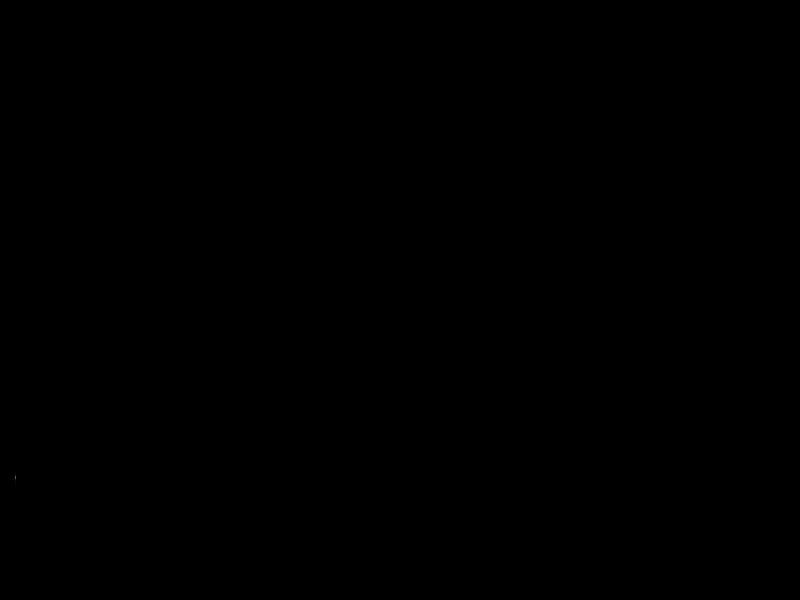

In [12]:
#do the bitwise AND of the mask and the frame
#mask_resized = cv2.resize(mask, (edges.shape[1], edges.shape[0]))
#mask = mask.astype('uint8')
#edges = edges.astype('uint8')
print(mask.shape)
print(edges.shape)

ROI = cv2.bitwise_and(mask, edges)
ROI_image = Image.fromarray(ROI)
display(ROI_image)

In [13]:
go_forward_leftside = 0
go_left_leftside = 0
go_right_leftside = 0
go_forward_rightside = 0
go_left_rightside = 0
go_right_rightside = 0
left_x_left_boundary = 50
left_x_right_boundary = 130
right_x_left_boundary = 650
right_x_right_boundary = 720

for j in range(470, 483):  # range of the bottom points of interests in Y
    for i in range(len(ROI[0])):
        if (i > left_x_left_boundary) and (i < left_x_right_boundary) and (ROI[j][i] > 200):
            go_forward_leftside = 1
            go_left_leftside = 0
            go_right_leftside = 0
        if (i <= left_x_left_boundary) and (ROI[j][i] > 200):
            go_forward_leftside = 0
            go_left_leftside = 1
            go_right_leftside = 0
        if (i >= left_x_right_boundary) and (i <= 400) and (ROI[j][i] > 200):
            go_forward_leftside = 0
            go_left_leftside = 0
            go_right_leftside = 1
        if (i > right_x_left_boundary) and (i < right_x_right_boundary) and (ROI[j][i] > 200):
            go_forward_rightside = 1
            go_left_rightside = 0
            go_right_rightside = 0
        if (i <= right_x_left_boundary) and (i >= 400) and (ROI[j][i] > 200):
            go_forward_rightside = 0
            go_left_rightside = 1
            go_right_rightside = 0
        if (i >= right_x_right_boundary) and (ROI[j][i] > 200):
            go_forward_rightside = 0
            go_left_rightside = 0
            go_right_rightside = 1

print("go_forward_leftside =", go_forward_leftside)
print("go_left_leftside =", go_left_leftside)
print("go_right_leftside =", go_right_leftside)
print("go_forward_rightside =", go_forward_rightside)
print("go_left_rightside =", go_left_rightside)
print("go_right_rightside =", go_right_rightside)


go_forward_leftside = 0
go_left_leftside = 0
go_right_leftside = 0
go_forward_rightside = 0
go_left_rightside = 0
go_right_rightside = 0


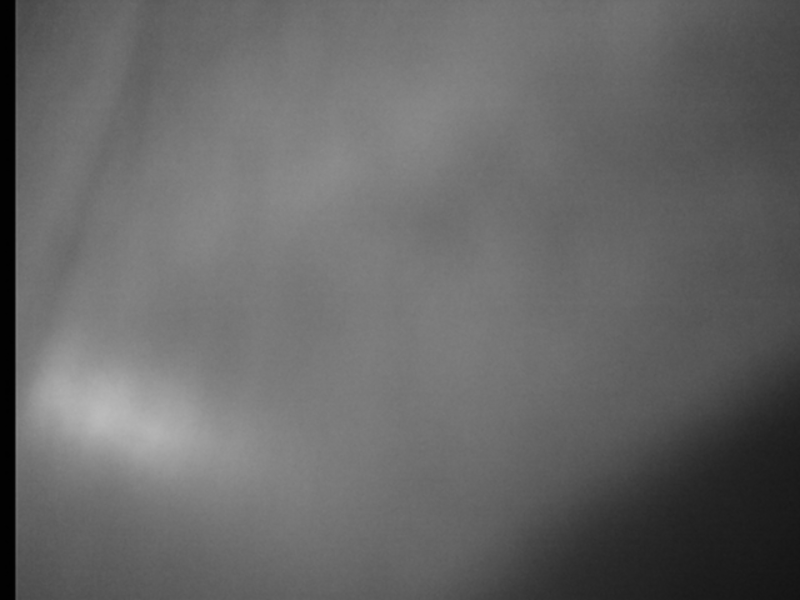

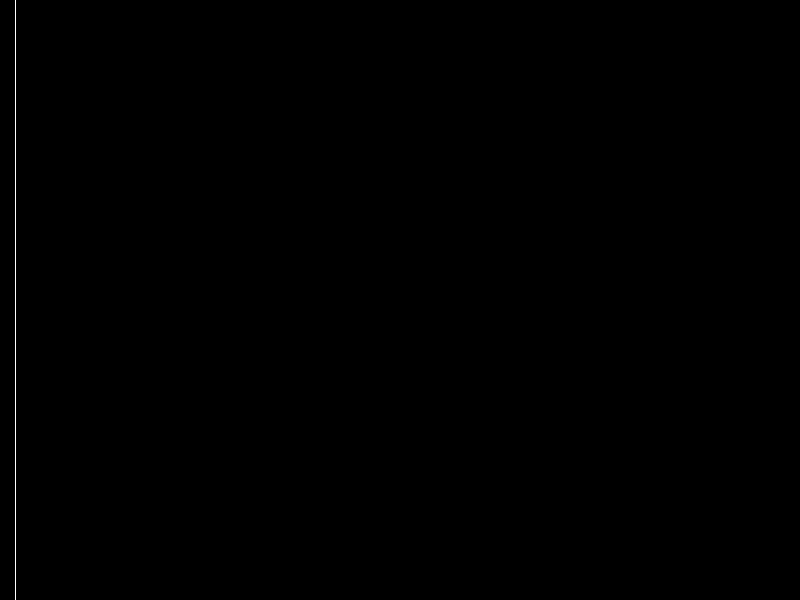

go_forward_leftside = 0
go_left_leftside = 0
go_right_leftside = 0
go_forward_rightside = 0
go_left_rightside = 0
go_right_rightside = 0


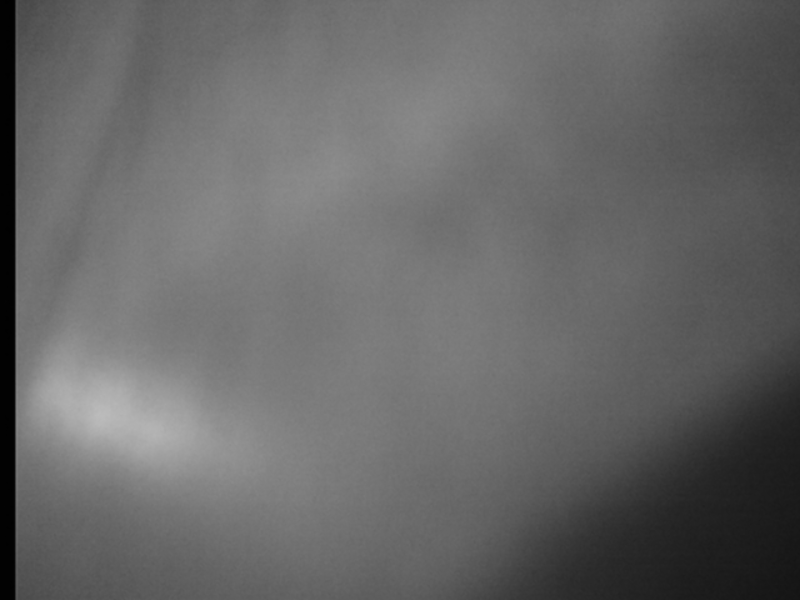

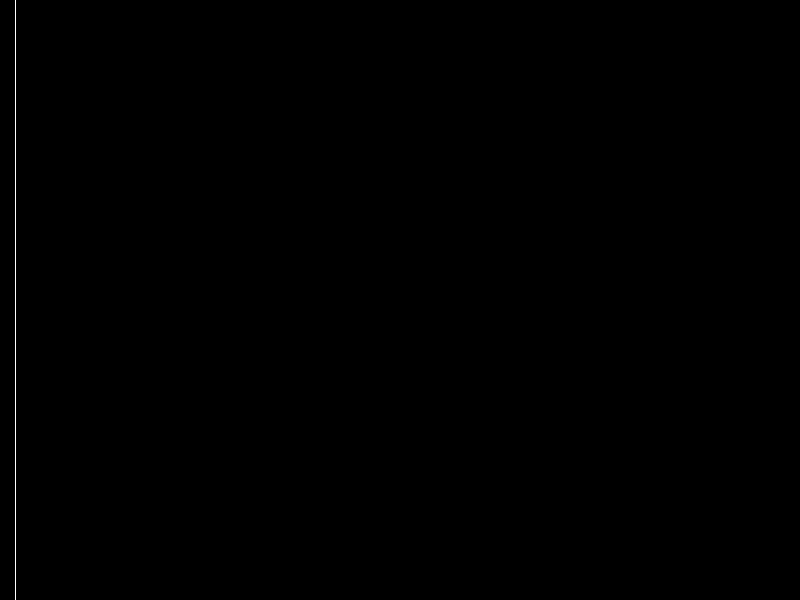

go_forward_leftside = 0
go_left_leftside = 0
go_right_leftside = 0
go_forward_rightside = 0
go_left_rightside = 0
go_right_rightside = 0


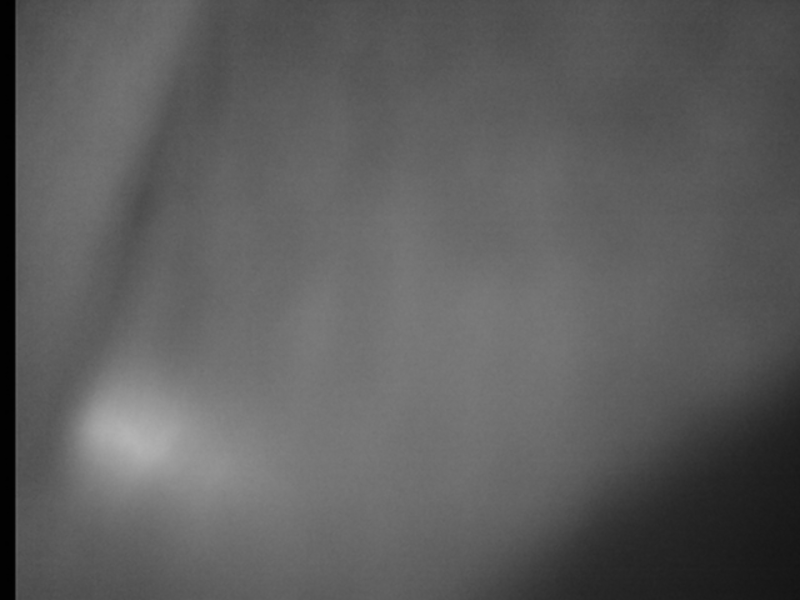

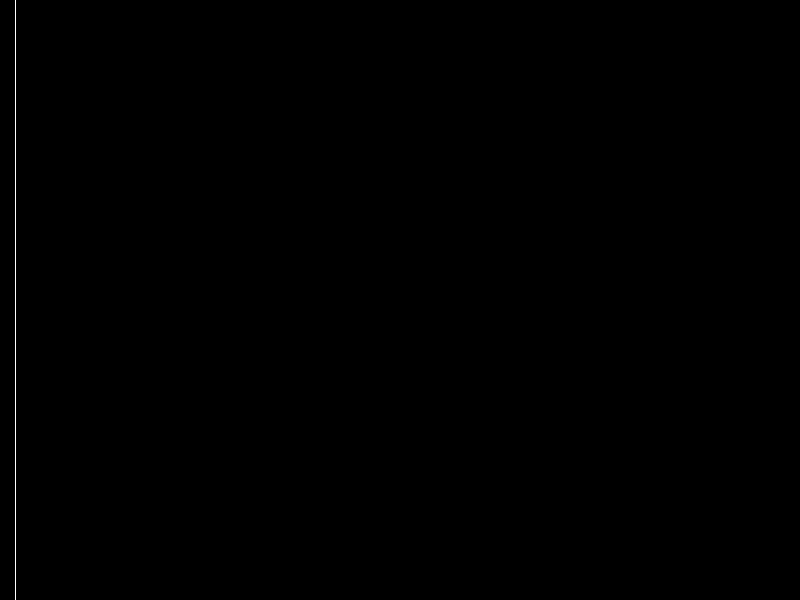

go_forward_leftside = 0
go_left_leftside = 0
go_right_leftside = 0
go_forward_rightside = 0
go_left_rightside = 0
go_right_rightside = 0


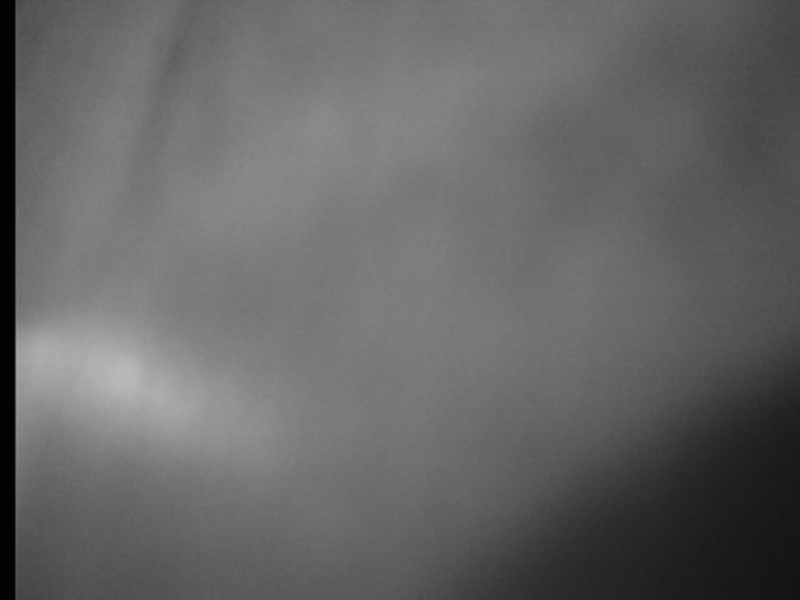

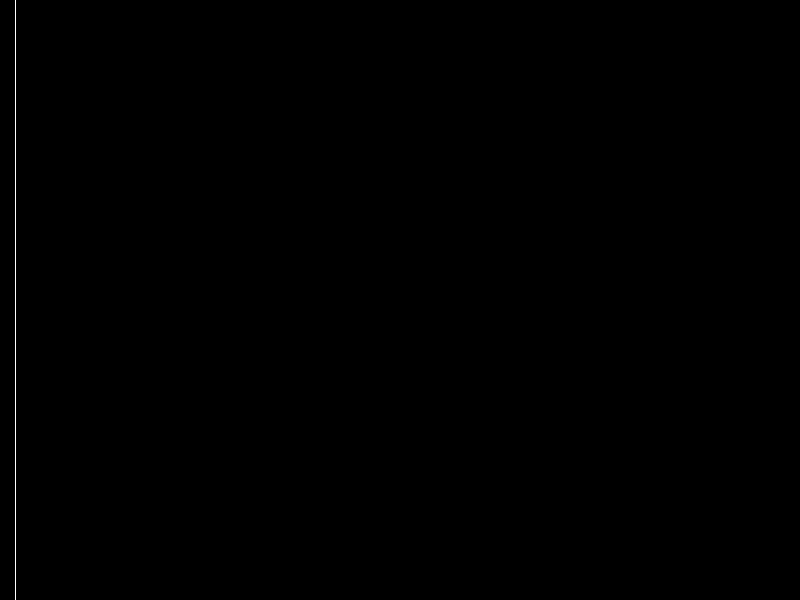

go_forward_leftside = 0
go_left_leftside = 0
go_right_leftside = 0
go_forward_rightside = 0
go_left_rightside = 0
go_right_rightside = 0


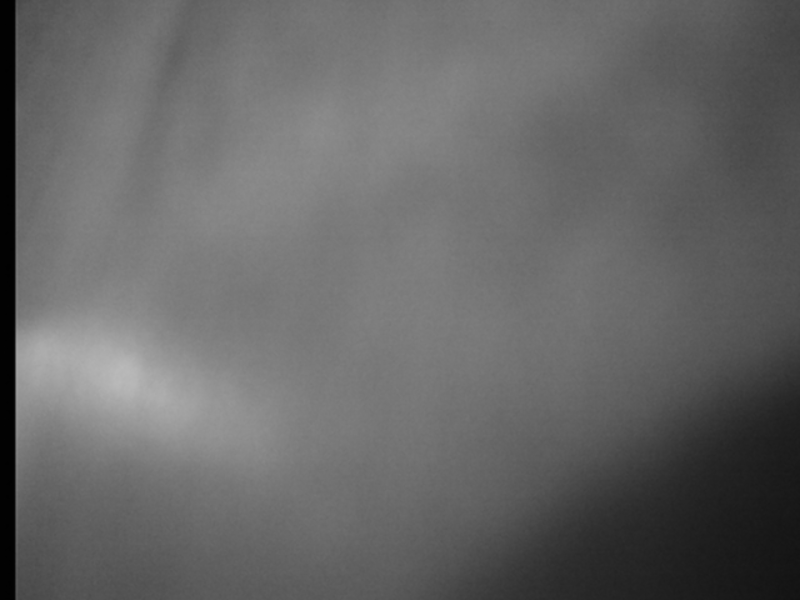

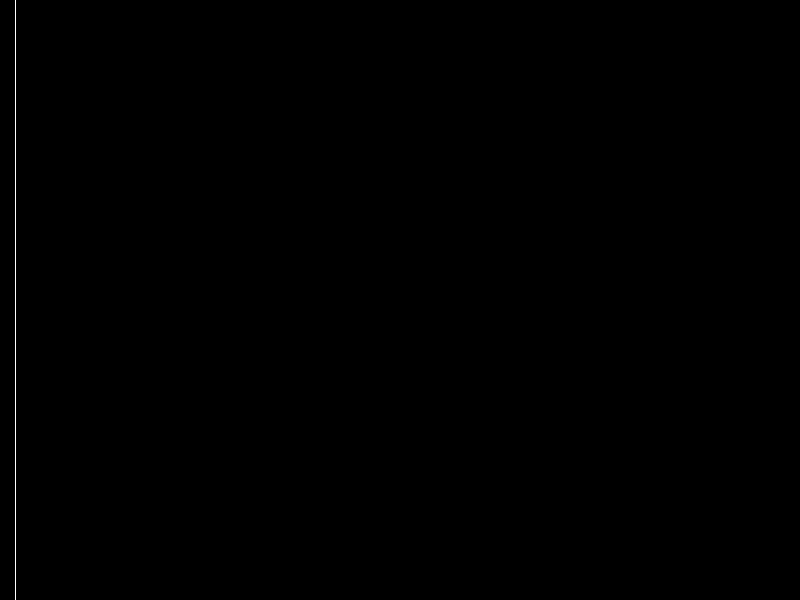

go_forward_leftside = 0
go_left_leftside = 0
go_right_leftside = 0
go_forward_rightside = 0
go_left_rightside = 0
go_right_rightside = 0


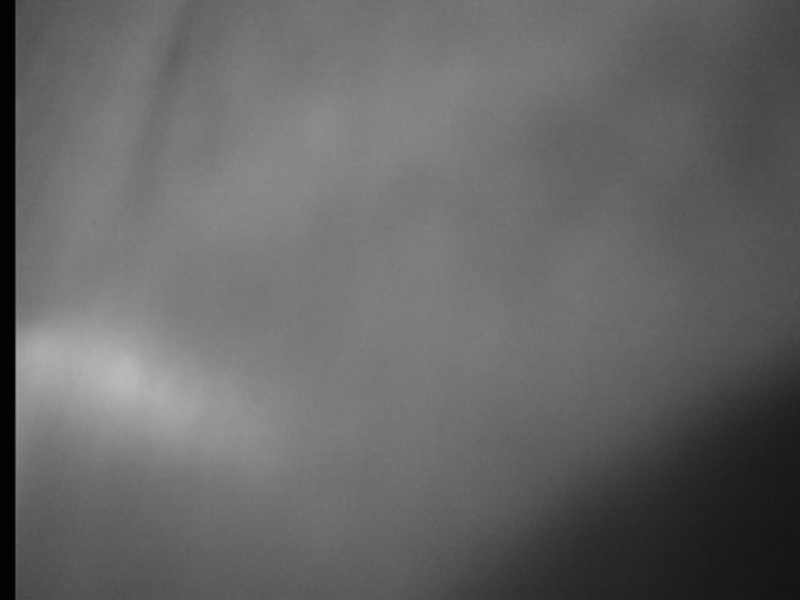

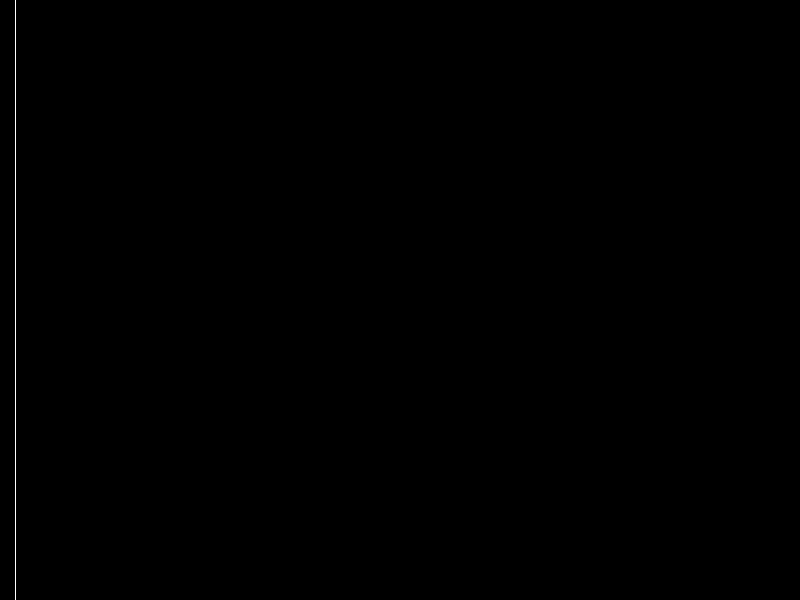

go_forward_leftside = 0
go_left_leftside = 0
go_right_leftside = 0
go_forward_rightside = 0
go_left_rightside = 0
go_right_rightside = 0


In [14]:
t_end = time.time() + 60 * 0.15
while time.time() < t_end:
    frame = vdma.readchannel.readframe()
    img = Image.fromarray(frame, 'RGB')
    display(img)
    # img.save("img.png")

    # Assuming 'frame' is your grayscale image from VDMA
    edges = cv2.Canny(frame, 100, 200)

    # Display the edges
    edges_img = Image.fromarray(edges)
    display(edges_img)    
    ROI = cv2.bitwise_and(mask, edges)
    
    go_forward_leftside = 0
    go_left_leftside = 0
    go_right_leftside = 0
    go_forward_rightside = 0
    go_left_rightside = 0
    go_right_rightside = 0
    left_x_left_boundary = 50
    left_x_right_boundary = 130
    right_x_left_boundary = 650
    right_x_right_boundary = 720
    for j in range(470, 483):  # range of the bottom points of interests in Y
        for i in range(len(ROI[0])):
            if (i > left_x_left_boundary) and (i < left_x_right_boundary) and (ROI[j][i] > 200):
                go_forward_leftside = 1
                go_left_leftside = 0
                go_right_leftside = 0
            if (i <= left_x_left_boundary) and (ROI[j][i] > 200):
                go_forward_leftside = 0
                go_left_leftside = 1
                go_right_leftside = 0
            if (i >= left_x_right_boundary) and (i <= 400) and (ROI[j][i] > 200):
                go_forward_leftside = 0
                go_left_leftside = 0
                go_right_leftside = 1
            if (i > right_x_left_boundary) and (i < right_x_right_boundary) and (ROI[j][i] > 200):
                go_forward_rightside = 1
                go_left_rightside = 0
                go_right_rightside = 0
            if (i <= right_x_left_boundary) and (i >= 400) and (ROI[j][i] > 200):
                go_forward_rightside = 0
                go_left_rightside = 1
                go_right_rightside = 0
            if (i >= right_x_right_boundary) and (ROI[j][i] > 200):
                go_forward_rightside = 0
                go_left_rightside = 0
                go_right_rightside = 1

    print("go_forward_leftside =", go_forward_leftside)
    print("go_left_leftside =", go_left_leftside)
    print("go_right_leftside =", go_right_leftside)
    print("go_forward_rightside =", go_forward_rightside)
    print("go_left_rightside =", go_left_rightside)
    print("go_right_rightside =", go_right_rightside)    
    